## CANB8347, Hossein Jashnsaz, Parameter Inference, April 6, spring 2023

## Objectives: 
- Set up ODE models for regulatory networks (a 3-node model)
- Using the model and a set of parameters, simulate time-dependent signaling data 
- Use the simulated data to estimate model parameters using a Bayesian optimization algorithm
- Visualize errors over the optimization iterations
- quantify the posterior and evaluate correlation among model parameters
- Evaluate model fits and predictions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import random
from scipy.integrate import solve_ivp, odeint
plt.style.use('seaborn-poster')
from sympy import pprint
import time
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
# import dill

### Stimuli functions
a step change in stimuli or drug over time

In [2]:
# step function
def step_fxn(t,step_time,step_size):
    if t<step_time:
        return 1
    else:
        return 1+step_size

## Model
### Network 
Inhoherent Feed-Forward Loop (IFFL) + Negative Feedback Loop (NFBL): <br>
input activates A <br>
A activates B <br>
A activates C <br>
C activates B <br>
B de-activates C <br>
A, B, C have basal deactivation <br>
input change as a step function

<img src="NetworkMotif.png" width="400" height="400"/>
<!-- ![](NetworkMotif.png) -->
<!-- ![NetworkMotif.png](attachment:NetworkMotif.png) -->

### Matrices

<img src="Matrices.png" width="400" height="400"/>
<!-- ![](Matrices.png) -->
<!-- ![Matrices.png](attachment:Matrices.png) -->

### ODEs

$$
\begin{align}
d{\bf A}/dt = k_1{\bf u}(t)(1-{\bf A}) - k_2b_1{\bf A} \\
d{\bf B}/dt = k_3{\bf A}(1-{\bf B}) + k_4{\bf C}(1-{\bf B}) - k_5b_2{\bf B} \\
d{\bf C}/dt = k_6{\bf A}(1-{\bf C}) -k_7{\bf B}{\bf C} - k_8b_3{\bf C}
\end{align}
$$

In [3]:
# number of nodes and number of parameters
n_nodes = 3
n_params = 8

### Regulation Functions

In [4]:
def mass_action(in1, in2, par): # mass action
    return par * in1 * in2

### define the model

In [5]:
IN = lambda t: step_fxn(t,0,.5) # set input function

# Network nodes names
NodesNames = ['[A]', '[B]', '[C]']
# Basal Regulation Matrix
b = np.array([[-1], [-1], [-1]])

In [6]:
def model(S,t):
    A = S[0]
    B = S[1]
    C = S[2]
    
    dAdt = A*mass_action(IN(t), (1-A), K[0]) + mass_action(b[0][0], A, K[1]) + .1*(IN(t)-1)*(1-A)
    dBdt = B*mass_action(A, (1-B), K[2]) + mass_action(C, (1-B), K[3]) + mass_action(b[1][0], B, K[4]) + .1*A*(1-B)
    dCdt = C*mass_action(A, (1-C), K[5]) - mass_action(B, C, K[6]) + mass_action(b[2][0], C, K[7]) + .1*A*(1-C)   
    # last terms in rates are added to acheive steady state initial condition of [0,0,0] for [A,B,C]   
    ODE=[dAdt, dBdt, dCdt]
    return ODE

### solving and plotting the model for a given parameter set

If we have a set of model parameters set, we can solve the model to obtain the time-dependent <br> concentration/activity of the nodes. 


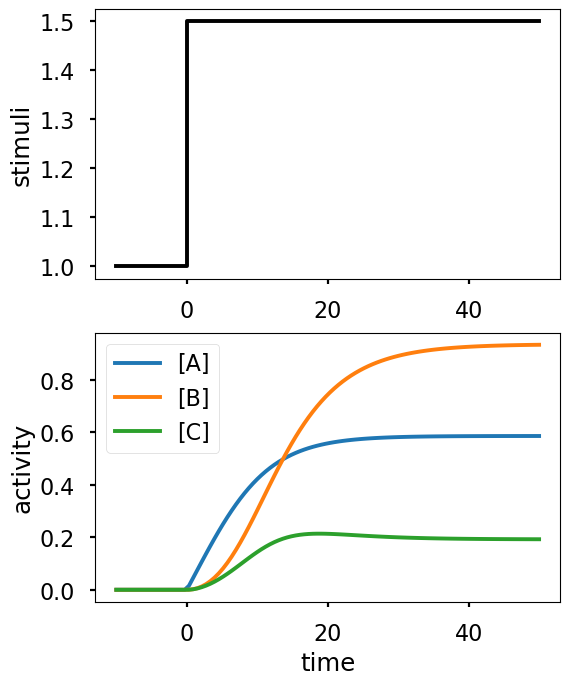

<Figure size 1280x880 with 0 Axes>

In [19]:
# solve the model for a given parameter set
TrueParameters=[.12,.11,.085,.2,.01,.6,.3,.25]
K = TrueParameters
S0 = [0,0,0] # Initial Conditions
t = np.linspace(-10,50,100) # timepoints
S = odeint(model,S0,t) # ODE solver

# plot the activity of the nodes
plt.figure(figsize=(6,7.7))
plt.subplot(211)
plt.step([-10,0,0,50], [1,1,1.5,1.5], '-k')
plt.ylabel('stimuli')

plt.subplot(212)
plt.plot(t,S)
plt.xlabel('time')
plt.ylabel('activity')
plt.legend(NodesNames)
plt.show()
plt.tight_layout()

## parameter inference

If we have measurements on the time-dependent activity of the nodes, can we infer<br> 
the model parameters from this dynamic measurements?

We will use synthetic data that we simulated from our model under our true parameter set,<br>
to estimate the parameters.    

In [20]:
# generate training data
noise = np.random.uniform(-.05,.05,[len(t),len(S0)]) # generate white noise (10%)
S = odeint(model,S0,t) + noise # add the noise to the model solutions
# place data into a pandas DataFrame
data = pd.DataFrame({'Time': t})
data[f'A'] = S[:,0]
data[f'B'] = S[:,1]
data[f'C'] = S[:,2]
print(data.head())

        Time         A         B         C
0 -10.000000 -0.021702  0.000222 -0.014668
1  -9.393939  0.012658  0.000231  0.031527
2  -8.787879 -0.036242  0.042098  0.004388
3  -8.181818  0.016502  0.032514 -0.026210
4  -7.575758 -0.008673  0.014891  0.040497


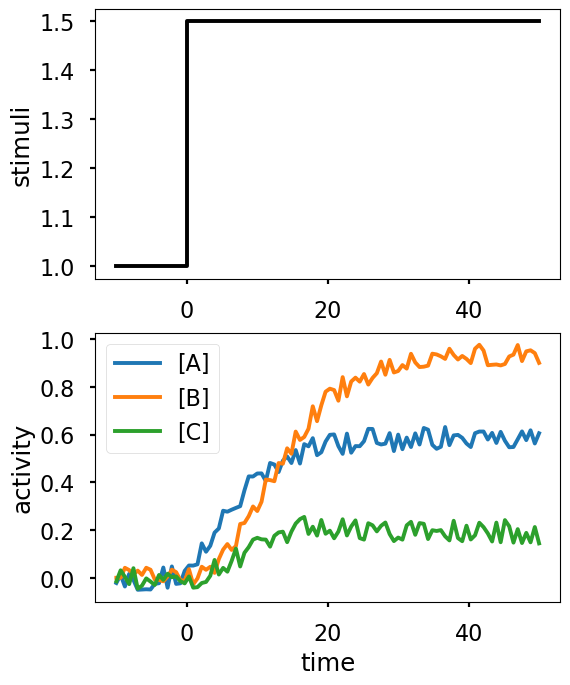

<Figure size 1280x880 with 0 Axes>

In [22]:
# plot the activity of the nodes
plt.figure(figsize=(6,7.7))
plt.subplot(211)
plt.step([-10,0,0,50], [1,1,1.5,1.5], '-k')
plt.ylabel('stimuli')

plt.subplot(212)
plt.plot(data.Time,data.A)
plt.plot(data.Time,data.B)
plt.plot(data.Time,data.C)
plt.xlabel('time')
plt.ylabel('activity')
plt.legend(NodesNames)
plt.show()
plt.tight_layout()

## optimization algorithm
- We will start from a uniform prior.<br> 
- At each iteration, we will sample __nSamples__ parameter sets from a multivariate distribution.<br> 
- We will solve the model for each set and evaluate the error ($ |Model-Data|^2 $).<br>  
- We will calculate the wighted means and covariances of the parameter sets. 
- repeat 

### sampling function

In [23]:
def sample(mu,sigma,nSamples,constrains):
    parameters = np.random.multivariate_normal(mu,sigma,nSamples) # multivariate normal distribution
    parameters[parameters>constrains.UB[0]] = constrains.UB[0]*(1-np.random.uniform(0,.1))
    parameters[parameters<constrains.LB[0]] = constrains.LB[0]*(1+np.random.uniform(0,.1))
    return parameters

### constrains and uniform prior

In [24]:
constrains = pd.DataFrame({'UB': 3.0,'LB': -3.0},index=[0])
nSamples = 1000
prior = np.random.uniform(constrains.LB[0],constrains.UB[0],[nSamples,n_params]) # sample uniform parameters in [-3,+3]
print(prior.shape)

(1000, 8)


### function to visualize parameters 

In [63]:
def plot_parameters(samples,means,TrueVals,constrains,colmap='BrBG',pcorr='no'):    
    # scatterplot of unique pairs of parameters, with each hist at diognals
    cmap = plt.cm.get_cmap(colmap) # BrBG PRGn coolwarm RdYIGn
    cmap.set_bad(color='k', alpha=None)
    n_params = samples.shape[1]
    fig, axs = plt.subplots(n_params, n_params, figsize=(20,20))
    for i in range(n_params):
        for j in range(n_params):
            if i == j:
                axs[i,j].hist(samples[:,i], alpha=0.5)
                if TrueVals!=[]:
                    axs[i,j].axvline(x = np.log10(TrueVals[i]), color = 'k', alpha=0.9)
                axs[i,j].set_xlabel('k'+str(i+1))
                axs[i,j].set_xlim([constrains.LB[0], constrains.UB[0]])
            elif i < j:
                axs[i,j].scatter(samples[:,j],samples[:,i], alpha=0.5)
                if means!=[]:
                    axs[i,j].scatter(means[j],means[i], alpha=0.9)
                if TrueVals!=[]:
                    axs[i,j].scatter(np.log10(TrueVals[j]),np.log10(TrueVals[i]),color = 'k', alpha=0.9)
                axs[i,j].set_xlim([constrains.LB[0], constrains.UB[0]])
                axs[i,j].set_ylim([constrains.LB[0], constrains.UB[0]])
                axs[i,j].tick_params(labelbottom=False, labelleft=False)
                if i==0 and j==1:
                    leg=['samples']
                    if means!=[]:
                        leg.append('mean')
                    if TrueVals!=[]:
                        leg.append('true')
                    axs[i,j].legend(leg)
            else:
                # do pearson statistical test to find statistically significant corrrelations 
                axs[i,j].axis('off')
                corr, pval = pearsonr(samples[:,j], samples[:,i])
                if abs(corr)>.05 and pval<=.05 and pcorr=='yes':
                    n_corr = .5*(corr+1)
                    axs[i,j].text(0,+.03, f"(k{i+1}, k{j+1})",ha='center',va='center',backgroundcolor=cmap(n_corr))
                    axs[i,j].text(0,.00,f"Corr: {corr:.2f}",ha='center',va='center',backgroundcolor=cmap(n_corr))
                    axs[i,j].text(0,-.03,f"p-value: {pval:.2f}",ha='center',va='center',backgroundcolor=cmap(n_corr))
                    axs[i,j].set_xlim([-1,1])
                    axs[i,j].set_ylim([-.1,.1])
#                     axs[j,i].set_facecolor(cmap(.5*(corr+1)))                       
    # plt.tight_layout()
    plt.show()
    return fig

/var/folders/57/x7l2n36578313lsdtz0p140m0000gn/T/ipykernel_38065/126371687.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cmap.set_bad(color='k', alpha=None)


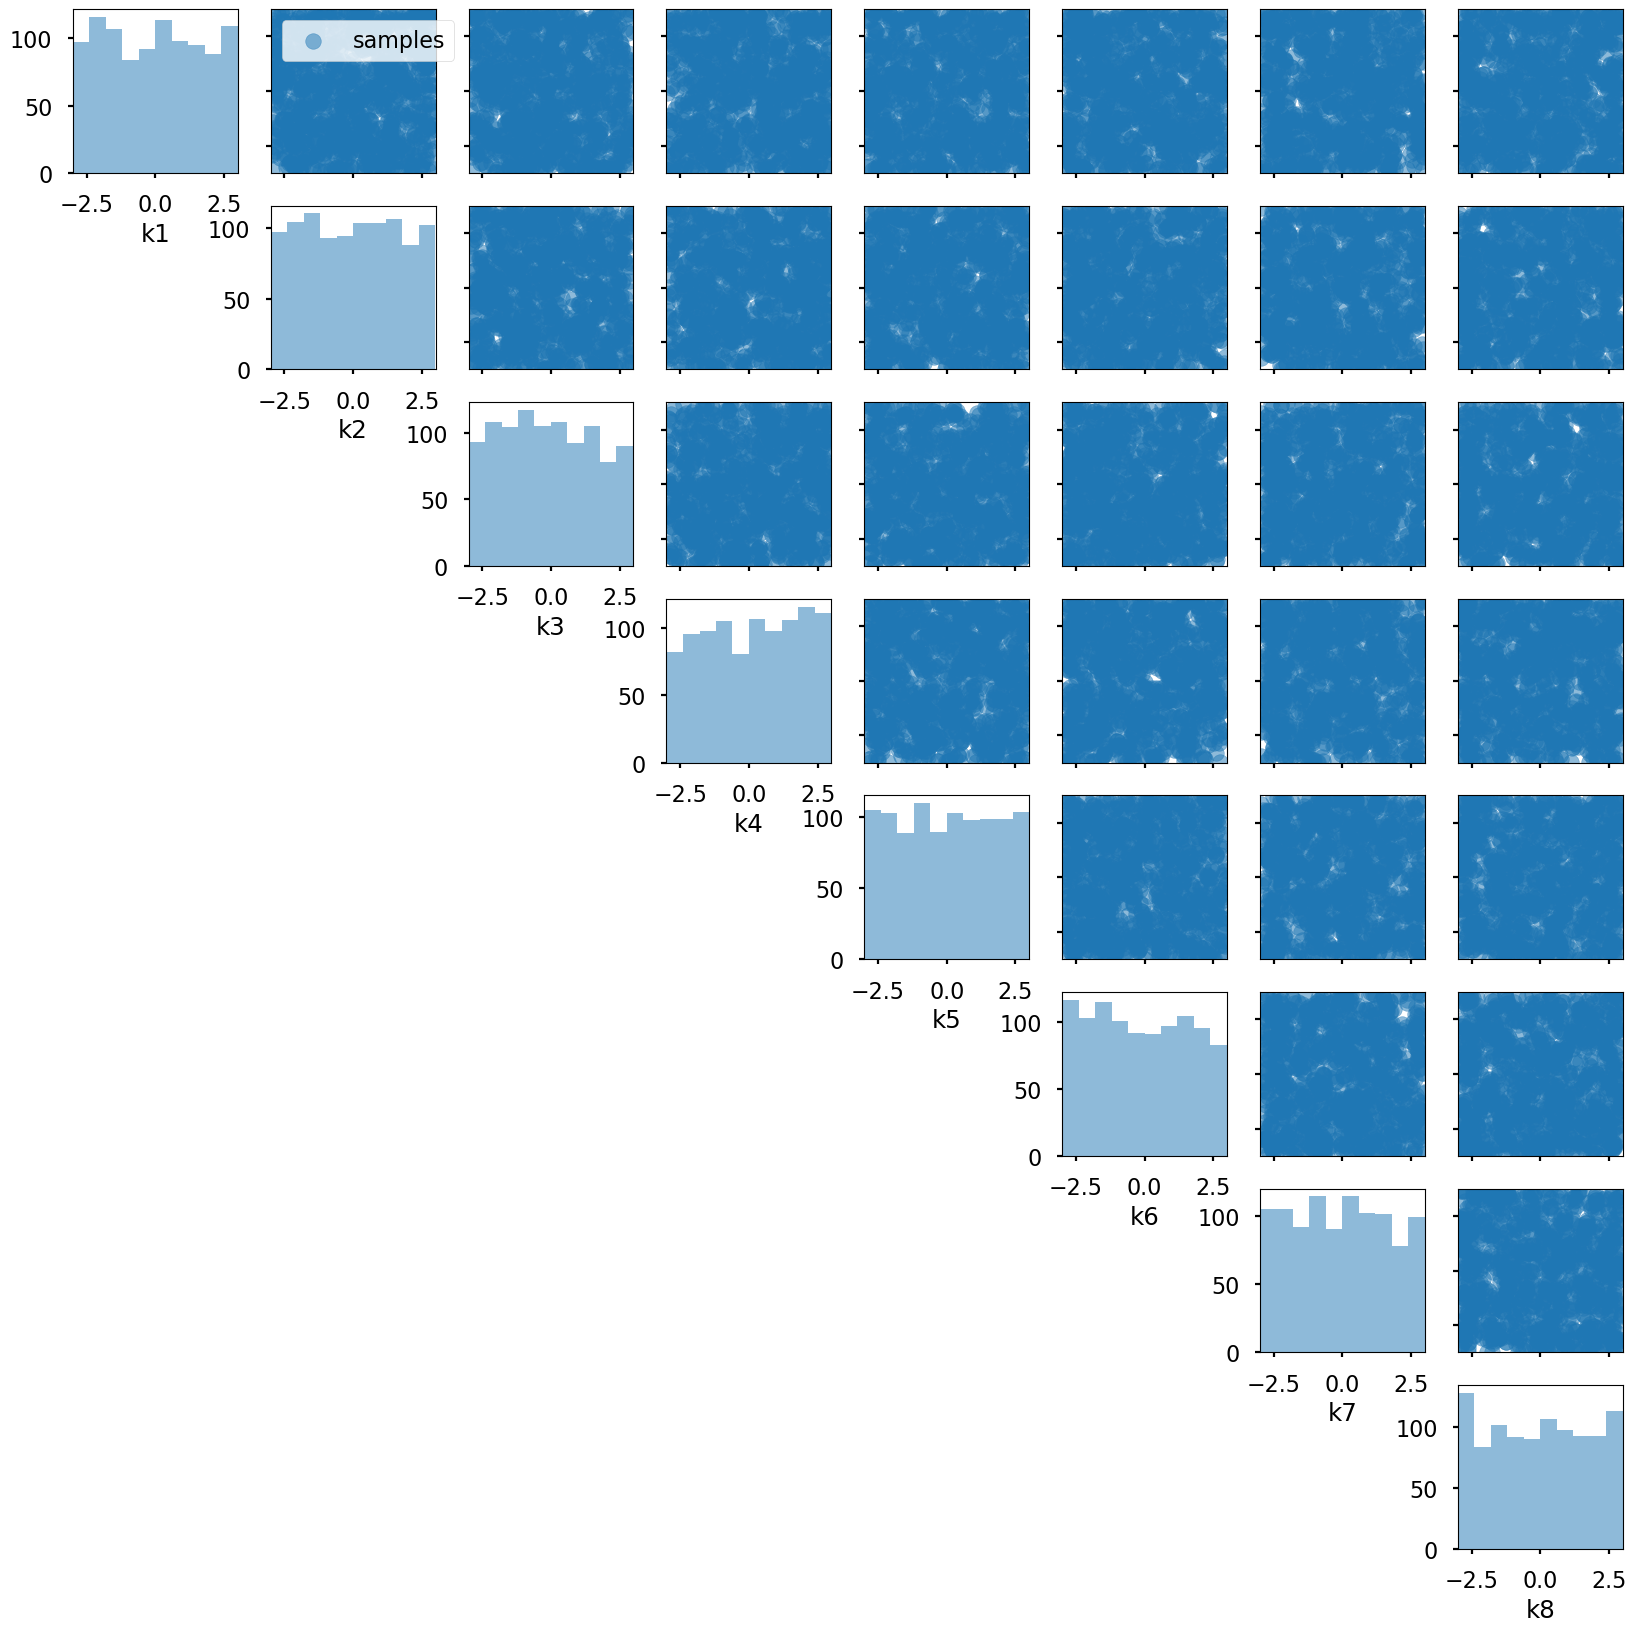

In [60]:
fig = plot_parameters(prior,[],[],constrains) # prior TrueParameters

mean, covariance, and the shape of prior

In [27]:
# mean and covariance of uniform prior 
mu0 = np.mean(prior,axis=0)
cov0 = np.cov(prior.T)
print(mu0.shape)
print(cov0.shape)
parameters = sample(mu0,cov0,100,constrains)
print(prior.shape)

(8,)
(8, 8)
(1000, 8)


/var/folders/57/x7l2n36578313lsdtz0p140m0000gn/T/ipykernel_38065/3316156441.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cmap.set_bad(color='k', alpha=None)
/var/folders/57/x7l2n36578313lsdtz0p140m0000gn/T/ipykernel_38065/3316156441.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if means!=[]:
/var/folders/57/x7l2n36578313lsdtz0p140m0000gn/T/ipykernel_38065/3316156441.py:26: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if means!=[]:


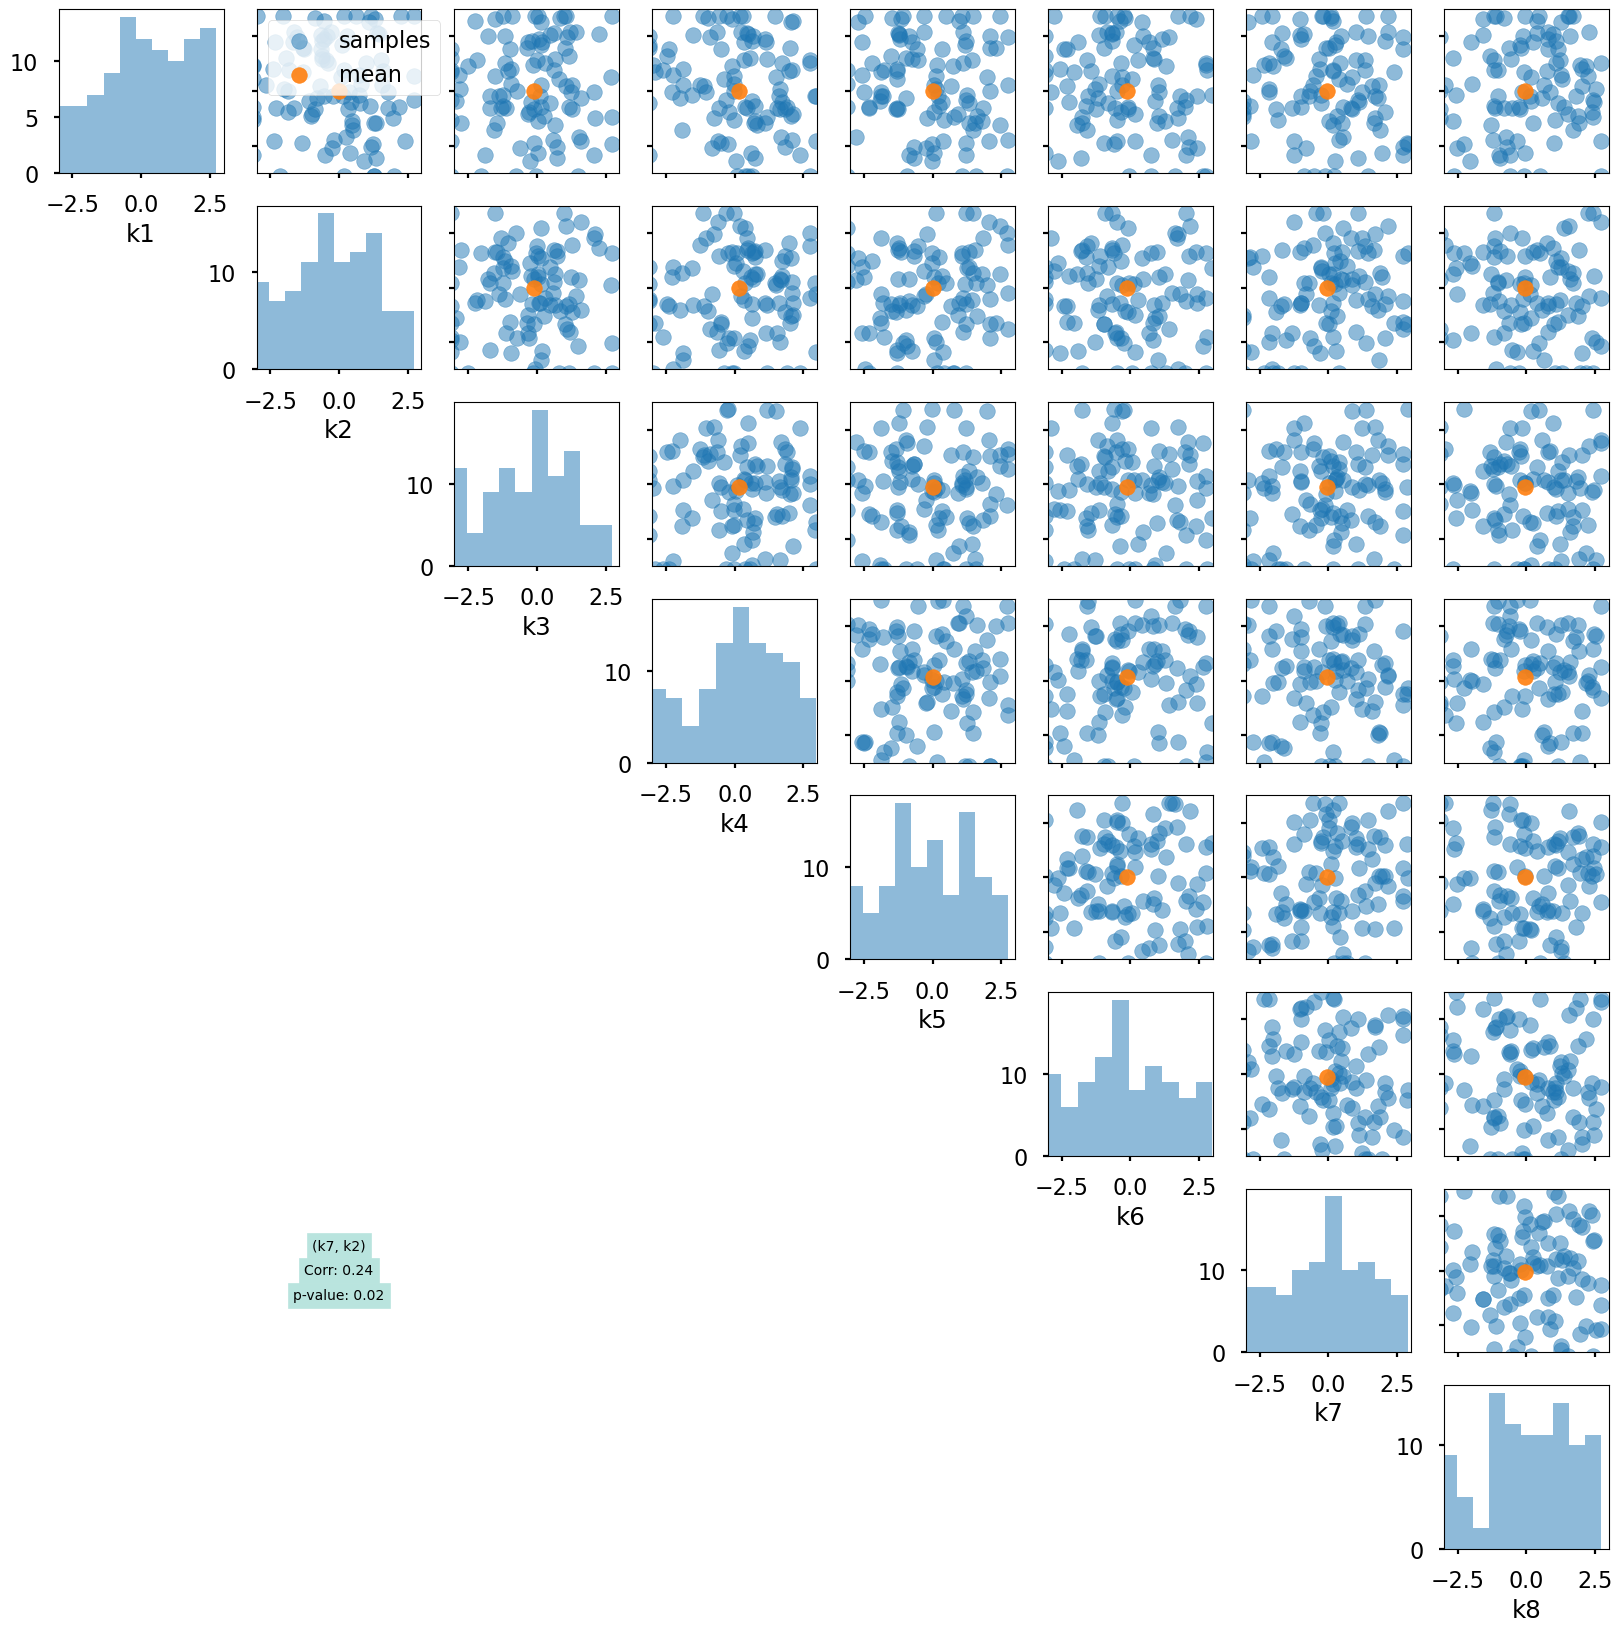

In [28]:
fig = plot_parameters(parameters,mu0,[],constrains) # example samples from multi-var normal dist

### Bayesian algorithm

In [29]:
iMax = 30
muu = mu0
covv = cov0
ERRORS = np.empty((iMax,4)) # initialize empty array to save errors
for i in range(iMax):
    t0=time.time()

    # sample parameter sets
    if i==0:
        parameters = prior
    else:
        parameters = sample(muu,covv,nSamples,constrains)

    # solve the model and calculate OBJ for each parameter set  
    OBJs = []
    for j in range(parameters.shape[0]): #paramsets.shape[0]
        K = 10**parameters[j,:] # parameter set j_th row
        S = odeint(model,S0,data.Time) # solve model for K
        error = np.nansum((S[:,2]-data.C)**2)+np.nansum((S[:,1]-data.B)**2)+np.nansum((S[:,0]-data.A)**2) # calculate the error between S and data
        OBJs.append(error)

    OBJs = np.nan_to_num(OBJs, nan=np.inf) # change any NaN to INF      
    sOBJs = np.sort(OBJs) # sort OBJs
    INXs = np.argsort(OBJs) # indices of sort

    OBJs[INXs[0:4]] = OBJs[INXs[4]] # flatten the lowest [5] of OBJs to the highest OBJ among them         

    # when OBJ gets smaller, the gradient becomes shallower, this sharpens the gradient
    if np.min(OBJs)<1:
        OBJs = 1e1*OBJs 
    elif np.min(OBJs)<1e-1: 
        OBJs = 1e2*OBJs
    elif np.min(OBJs)<1e-2: 
        OBJs = 1e3*OBJs
    elif np.min(OBJs)<1e-3: 
        OBJs = 1e4*OBJs
    elif np.min(OBJs)<1e-4:
        OBJs = 1e5*OBJs

    nL=np.exp(-OBJs)/np.sum(np.exp(-OBJs))  # likelihood of parameter sets
#     print(nL)        
    # calculate weighted mean and covariance based on the likelihood values
    nL = np.ravel(nL)
    this_mu = np.average(parameters, axis=0, weights=nL) # weighted mean of parameters
    this_cov = np.cov(parameters.T, aweights=nL) # weighted coveriance of parameters

    # add inertia terms to mu and cov
    muu = .5*this_mu+(1-.5)*muu
    covv = .5*this_cov+(1-.5)*covv

    if (i<iMax/2):
        covv = covv + 1e-2*np.eye(n_params)
    covv = .5*(covv+covv.T)

    min_obj = sOBJs[0]
    tf=time.time()
    if i%1==0:
        print('i = ' + str(i) + ' finished, best OBJ value is ' + str(np.round(min_obj,4)))
        print('time = '+ str(np.round(tf-t0,2)) + 'sec')
        print(' ')
    ERRORS[i,:] = [np.nanmean(OBJs), np.nanstd(OBJs), min_obj, np.round(tf-t0,2)]

/Users/hosseinjashnsaz/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


i = 0 finished, best OBJ value is 3.8513
time = 5.42sec
 
i = 1 finished, best OBJ value is 2.2057
time = 5.8sec
 
i = 2 finished, best OBJ value is 1.7946
time = 5.88sec
 
i = 3 finished, best OBJ value is 0.7378
time = 5.44sec
 
i = 4 finished, best OBJ value is 0.6856
time = 4.96sec
 
i = 5 finished, best OBJ value is 0.5523
time = 5.0sec
 
i = 6 finished, best OBJ value is 0.449
time = 3.86sec
 
i = 7 finished, best OBJ value is 0.4061
time = 3.46sec
 
i = 8 finished, best OBJ value is 0.4434
time = 3.23sec
 
i = 9 finished, best OBJ value is 0.3466
time = 3.29sec
 
i = 10 finished, best OBJ value is 0.3029
time = 3.5sec
 
i = 11 finished, best OBJ value is 0.3976
time = 3.55sec
 
i = 12 finished, best OBJ value is 0.3732
time = 3.27sec
 
i = 13 finished, best OBJ value is 0.2813
time = 3.25sec
 
i = 14 finished, best OBJ value is 0.3083
time = 3.38sec
 
i = 15 finished, best OBJ value is 0.3125
time = 3.69sec
 
i = 16 finished, best OBJ value is 0.2709
time = 3.8sec
 
i = 17 finis

### plotting OBJs (errors) over iterations

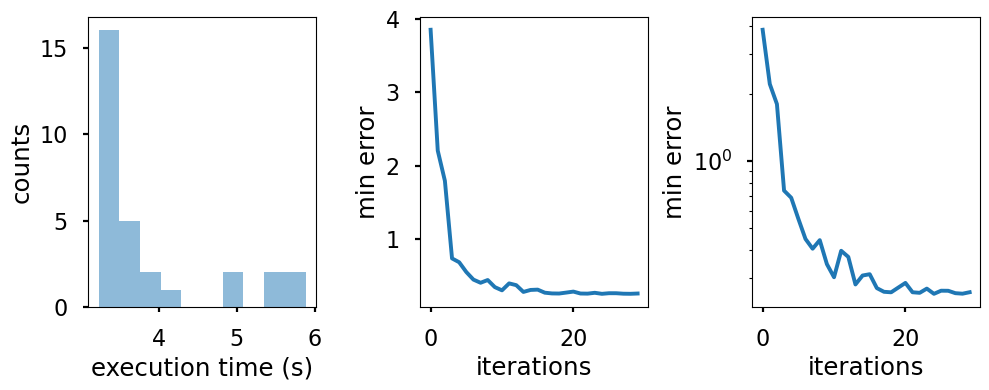

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(10,4))
axs[0].hist(ERRORS[:,3], alpha=0.5)
axs[0].set_xlabel('execution time (s)')
axs[0].set_ylabel('counts')
# axs[0,1].set_xlim([constrains.LB[0], constrains.UB[0]])

axs[1].plot(ERRORS[:,2])
axs[1].set_xlabel('iterations')
axs[1].set_ylabel('min error')

axs[2].plot(ERRORS[:,2])
axs[2].set_xlabel('iterations')
axs[2].set_ylabel('min error')
axs[2].set_yscale('log')
plt.tight_layout()

### posterior 
sample parameters from the posterior<br>
histogram individual parameters<br>
scatterplot each pair of parameters<br>
get correlation between each pair of parameters (pearson)<br>
print corr values if the corrrelation is significant (pvalue<0.05 and corr > 0.05)<br>

In [1]:
# cmap = plt.cm.get_cmap('BrBG')
# cmap.set_bad(color='k', alpha=None)
# cmap

/var/folders/57/x7l2n36578313lsdtz0p140m0000gn/T/ipykernel_38065/2070577096.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cmap.set_bad(color='k', alpha=None)


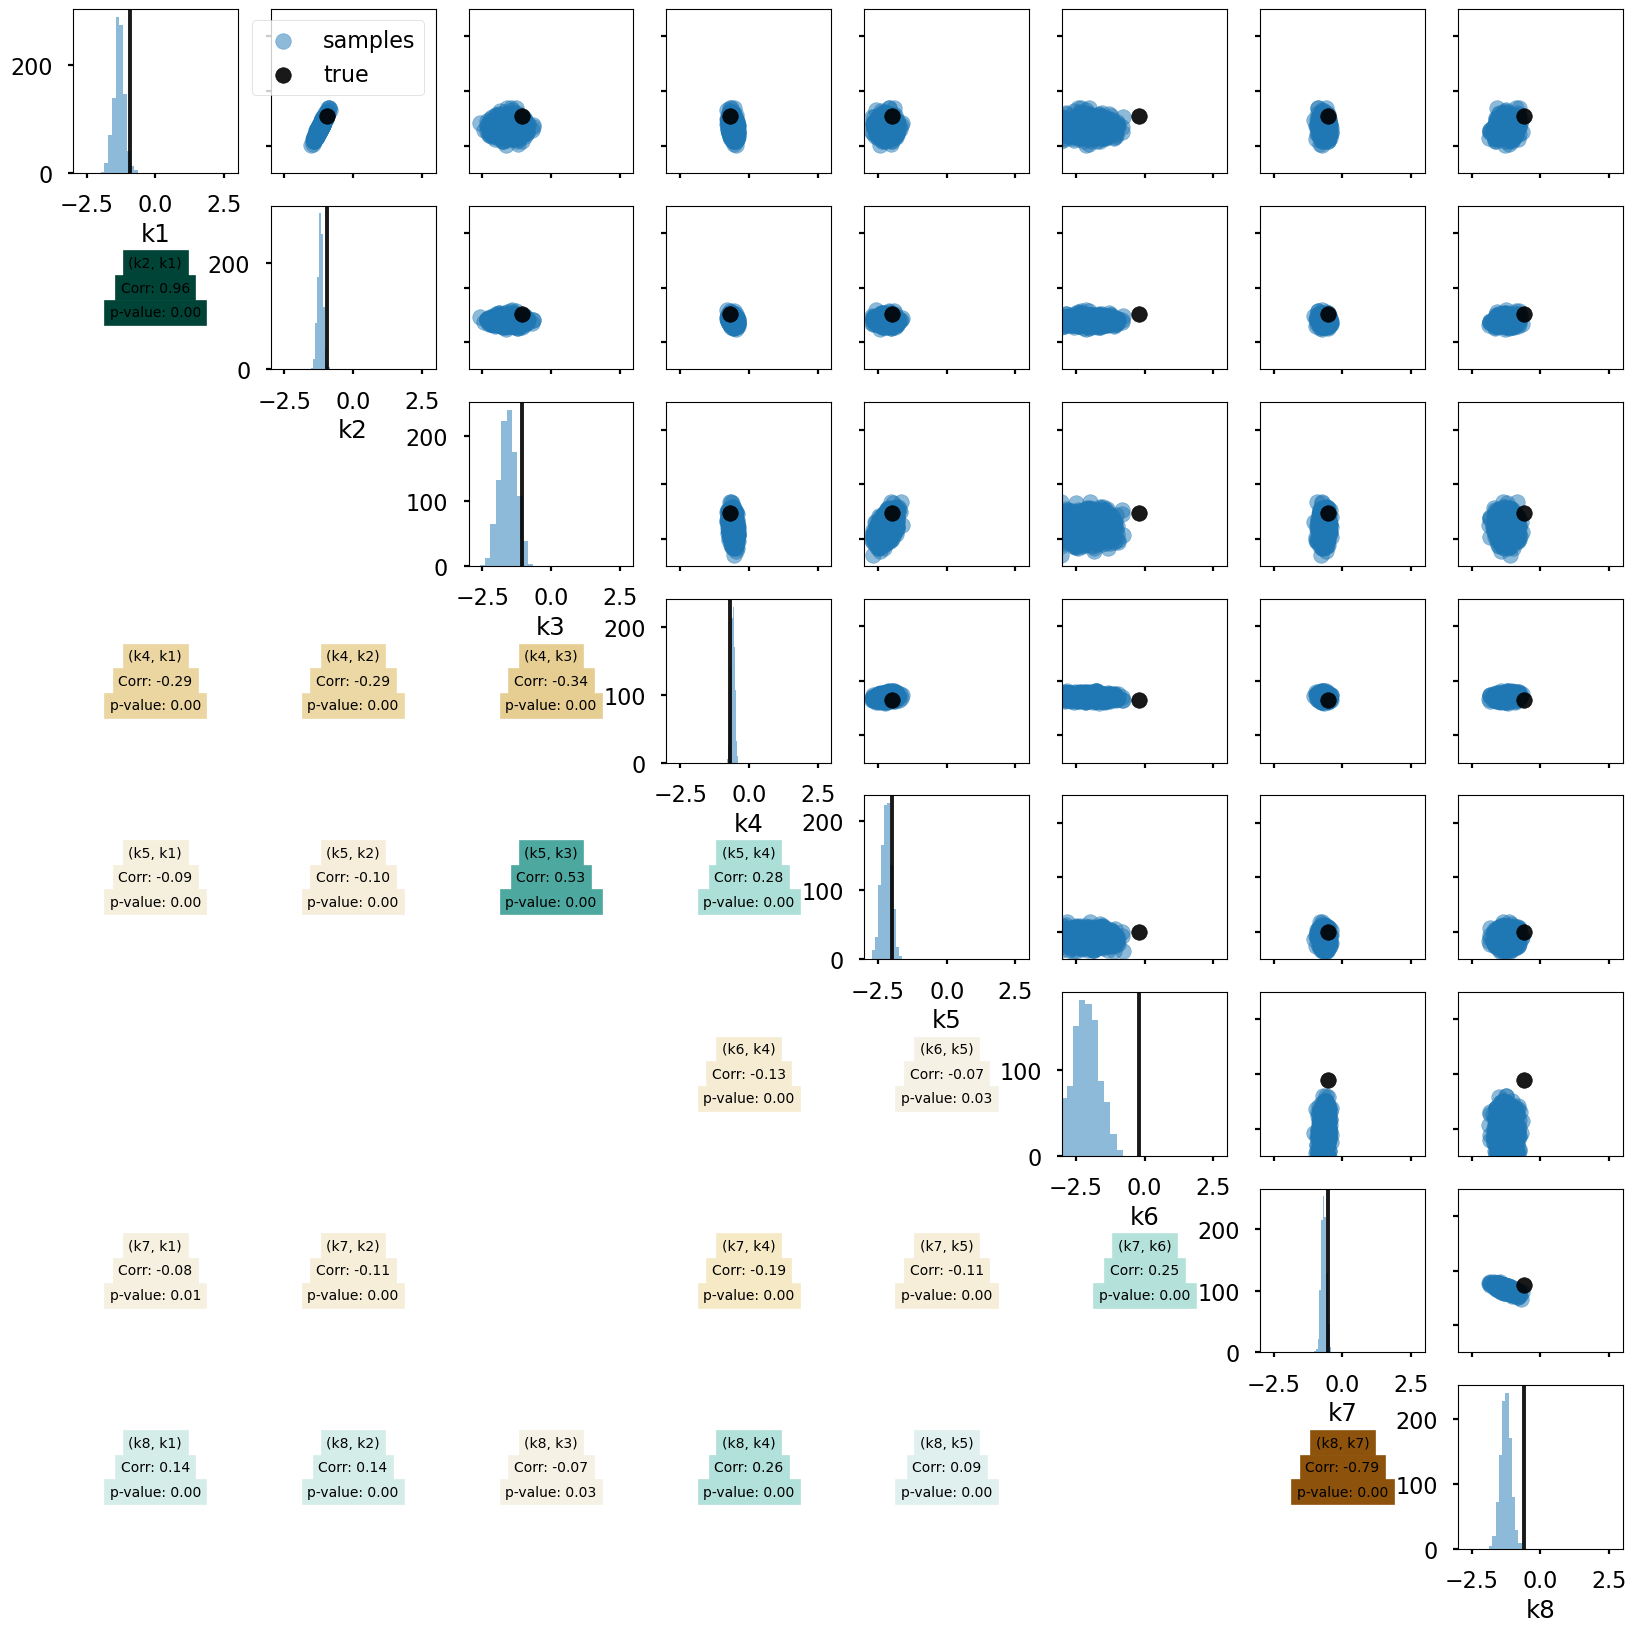

In [70]:
parameters = sample(muu,covv,1000,constrains)
fig = plot_parameters(parameters,[],TrueParameters,constrains,colmap='BrBG',pcorr='yes')

### correlation 
plot correlations between each pairs of parameters<br>

<AxesSubplot:>

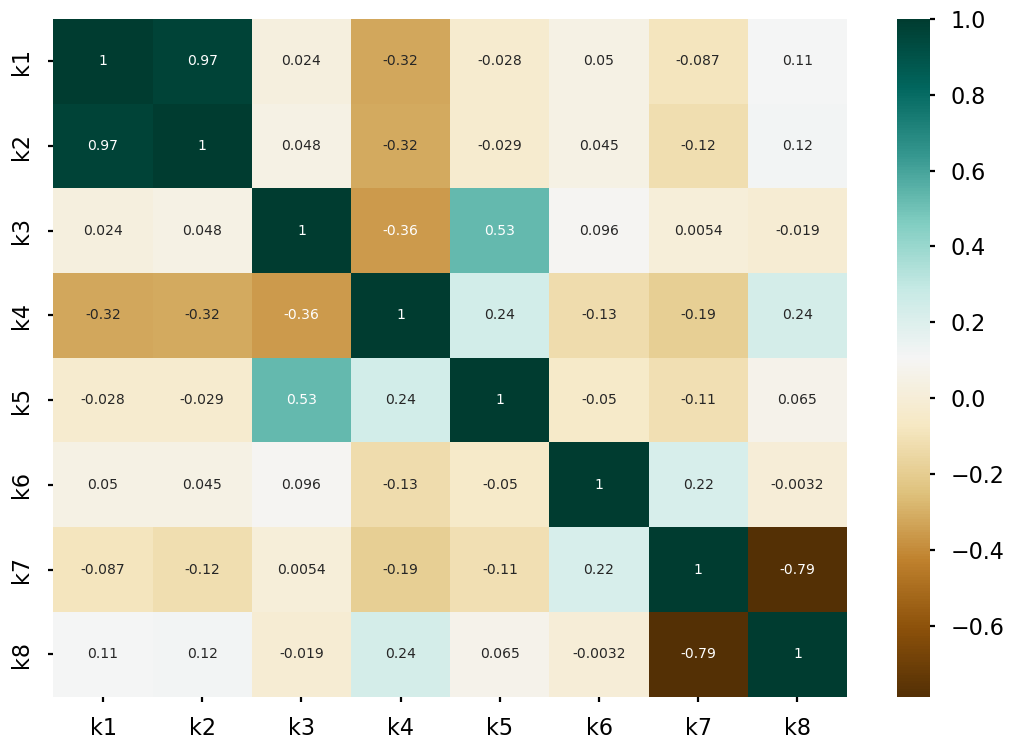

In [33]:
params_labels = ['k{}'.format(i) for i in range(1, n_params+1)]
df_parameters = pd.DataFrame(parameters,columns=params_labels)
sb.heatmap(df_parameters.corr(),annot=True,cmap='BrBG')

### quantifying parameters uncertainty 
calculate the determinant of covariance of parameters.<br>
determinant provide a measure of N-D volume in the space of N parameters. <br>
$ Det \propto \Delta k_1 * \Delta k_2* ... *\Delta k_8 $

In [34]:
print(np.linalg.det(cov0)) # the determinant of covariance of prior
print(np.linalg.det(covv)) # the determinant of covariance of posterior

6459.270297003112
2.1738451840111267e-15


### evaluate model solutions at posterior
sample parameters from the posterior<br>
for each parameter set get the model fits and predictions <br>

In [44]:
# function to plot fits and predictions
def plot_sols(data,m,s,col,du):
    
    # plot the activity of the nodes
    plt.figure(figsize=(6,7.7))
    plt.subplot(211)
    plt.step([-10,0,0,50], [1,1,1+du,1+du], '-k')
    plt.ylabel('stimuli')

    plt.subplot(212)
    # plot the data
    plt.plot(data.Time,data.A)
    plt.plot(data.Time,data.B)
    plt.plot(data.Time,data.C)
    plt.legend(NodesNames)

    # plot model fits and predictions
    for i in range(m.shape[1]):
        plt.plot(data.Time,m[:,i],col)
        plt.fill_between(data.Time, m[:,i]-s[:,i],m[:,i]+s[:,i],
         alpha=0.5, edgecolor=col, facecolor=col,
         linewidth=4, linestyle='dashdot', antialiased=True)
        
    plt.xlabel('time')
    plt.ylabel('activity')
    
    plt.tight_layout()
#     plt.ylim(-.01,1.1)
    return fig

In [45]:
# sample from the posterior
parameters = sample(muu,covv,50,constrains)

### evaluate model fits

In [46]:
# get model fits: solve the model at the sampled parameter sets
sols=np.empty((len(data.Time),len(S0),50)) # initialize empty array for the solutions
for j in range(parameters.shape[0]):
    K = 10**parameters[j,:] # parameter set j_th row
    sols[:,:,j] = odeint(model,S0,data.Time) # solve model for K
sols_std = np.std(sols,axis=2) # std of the solutions

# solve the model at mean posterior
K=10**muu
sols_mean = odeint(model,S0,data.Time) # ODE solver

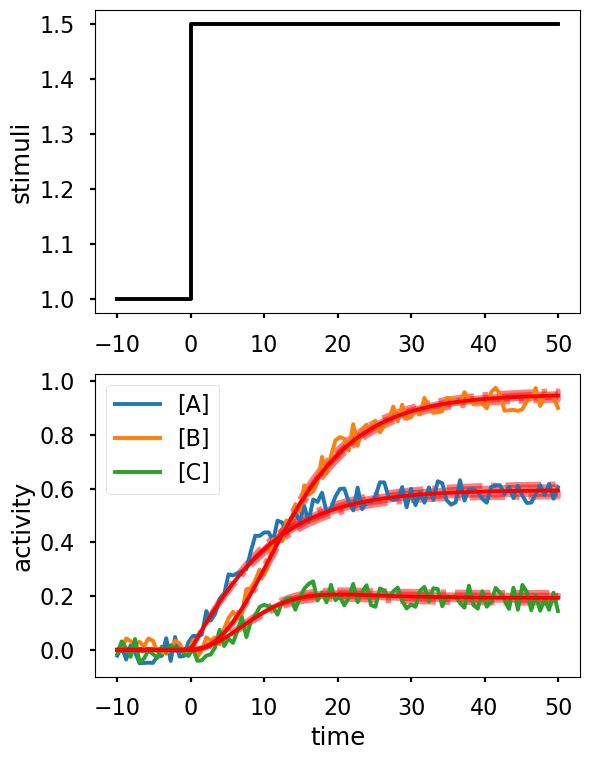

In [47]:
fig = plot_sols(data,sols_mean,sols_std,'r',.5) # traindata (ble, orange, green) and fits (red)

### simulate new dataset (test data) to evaluate model predictions

In [48]:
# a new input change from 1 to 3 at t=0
IN2 = lambda t: step_fxn(t,0,3) # set input function

def model(S,t):
    A = S[0]
    B = S[1]
    C = S[2]
    
    dAdt = A*mass_action(IN2(t), (1-A), K[0]) + mass_action(b[0][0], A, K[1])+.1*(IN2(t)-1)*(1-A)
    dBdt = B*mass_action(A, (1-B), K[2]) + mass_action(C, (1-B), K[3]) + mass_action(b[1][0], B, K[4])+.1*A*(1-B)
    dCdt = C*mass_action(A, (1-C), K[5]) - mass_action(B, C, K[6]) + mass_action(b[2][0], C, K[7]) +.1*A*(1-C)           
    
    ODE=[dAdt, dBdt, dCdt]
    return ODE

        Time         A         B         C
0 -10.000000  0.022999  0.049322  0.011700
1  -9.393939 -0.046794  0.002110  0.016924
2  -8.787879 -0.005611  0.005931  0.027305
3  -8.181818 -0.005585 -0.044335 -0.016479
4  -7.575758 -0.022064 -0.034739 -0.049047


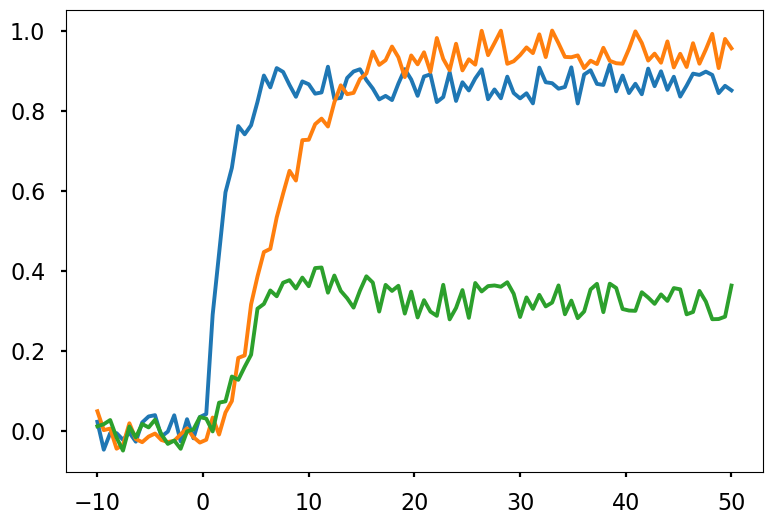

In [49]:
# generate test data
noise = np.random.uniform(-.05,.05,[len(t),len(S0)]) # generate white noise (10%)
K = TrueParameters
S = odeint(model,S0,t) + noise # add the noise to the model solutions

data = pd.DataFrame({'Time': t})
data[f'A'] = S[:,0]
data[f'B'] = S[:,1]
data[f'C'] = S[:,2]
print(data.head())

plt.figure(figsize=(9,6))
plt.plot(data.Time,S)

### evaluate model predictions

In [50]:
# get model predictions: solve the model at the sampled parameter sets
sols=np.empty((len(data.Time),len(S0),50)) # initialize empty array for the solutions
for j in range(parameters.shape[0]):
    K = 10**parameters[j,:] # parameter set j_th row
    sols[:,:,j] = odeint(model,S0,data.Time) # solve model for K
sols_std = np.std(sols,axis=2) # std of the solutions

# solve the model at mean posterior
K=10**muu
sols_mean = odeint(model,S0,data.Time) # ODE solver

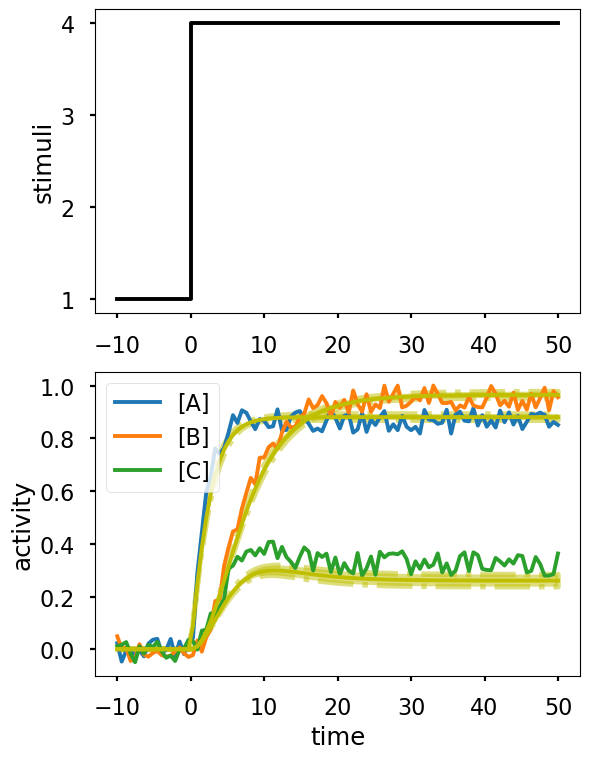

In [51]:
fig = plot_sols(data,sols_mean,sols_std,'y',3) # testdata (ble, orange, green) and predictions (yellow)

### Considerations 
- See Refs [1] and [2] for detailed analysis, and using temporal cell stimulations.
- Here, we used the activity of A, B, and C together to estimate the parameters. In experiments, often it is not feasible to measure all the nodes of a network. We can use the activity of one or two nodes to estimate the parameters and predict the other(s) nodes activity. 
- The relationship between the uncertainty in the model parameters (posterior) and the observables fits and predictions. 
- Implementation of mutant or inhibition conditions that could be done in experiments, in the model.
- Different optimization algorithms (MCMC, Metropolis–Hastings, Simulated Annealing, Genetic Algorithm), parallelization, and building the model using PySB and other packages.
- Supervised learning (identifying patterns in data based on known patterns such as pattern recognition or classification), unsupervised learning (identifying hidden patterns), versus Reinforcement learning. Different Machine Learning Approaches. 

### References
[1] Building predictive signaling models by perturbing yeast cells with time-varying stimulations resulting in distinct signaling responses, H Jashnsaz, ZR Fox, BE Munsky, and G Neuert. _STAR Protocols_, 2, 100660, 2021<br>
[2] Diverse cell stimulation kinetics identify predictive signal transduction models, H Jashnsaz, ZR Fox, JJ Hughes, G Li, BE Munsky, and G Neuert. _iScience_, 23, 101565, 2020<br>
[3] Pattern Recognition and Machine Learning by Christopher M. Bishop